# Balance model complexity and cross-validated score

This example balances model complexity and cross-validated score by finding a decent accuracy within 1 standard deviation of the best accuracy score while minimising the number of PCA components


In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [76]:
def lower_bound(cv_results):
    """
    Calculate the lower bound within 1 standard deviation
    of the best `mean_test_scores`.

    Parameters
    ----------
    cv_results : dict of numpy(masked) ndarrays
        See attribute cv_results_ of `GridSearchCV`

    Returns
    -------
    float
        Lower bound within 1 standard deviation of the
        best `mean_test_score`.
    """
    best_score_idx = np.argmax(cv_results["mean_test_score"])

    return (
        cv_results["mean_test_score"][best_score_idx]
        - cv_results["std_test_score"][best_score_idx]
    )

In [77]:
def best_low_complexity(cv_results):
    """
    Balance model complexity with cross-validated score.

    Parameters
    ----------
    cv_results : dict of numpy(masked) ndarrays
        See attribute cv_results_ of `GridSearchCV`.

    Return
    ------
    int
        Index of a model that has the fewest PCA components
        while has its test score within 1 standard deviation of the best
        `mean_test_score`.
    """
    threshold = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(cv_results["mean_test_score"] >= threshold)
    best_idx = candidate_idx[
        cv_results["param_reduce_dim__n_components"][candidate_idx].argmin()
    ]
    return best_idx

In [78]:
pipe = Pipeline(
    [
        ("reduce_dim", PCA(random_state=42)),
        ("classify", LinearSVC(random_state=42, C=0.01)),
    ]
)

In [79]:
pipe

Pipeline(steps=[('reduce_dim', PCA(random_state=42)),
                ('classify', LinearSVC(C=0.01, random_state=42))])

In [80]:
param_grid = {"reduce_dim__n_components": [6, 8, 10, 12, 14]}

grid = GridSearchCV(
    pipe,
    cv=10,
    n_jobs=1,
    param_grid=param_grid,
    scoring="accuracy",
    refit=best_low_complexity,
)

In [81]:
X, y = load_digits(return_X_y=True)

In [85]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [89]:
pd.DataFrame(y).value_counts()

,count
0,
3,183
1,182
5,182
4,181
6,181
9,180
7,179
0,178
2,177


In [90]:
grid.fit(X, y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('reduce_dim', PCA(random_state=42)),
                                       ('classify',
                                        LinearSVC(C=0.01, random_state=42))]),
             n_jobs=1,
             param_grid={'reduce_dim__n_components': [6, 8, 10, 12, 14]},
             refit=<function best_low_complexity at 0x793dd402eef0>,
             scoring='accuracy')

In [91]:
n_components = grid.cv_results_["param_reduce_dim__n_components"]
test_scores = grid.cv_results_["mean_test_score"]

In [93]:
test_scores

array([0.77460273, 0.84532278, 0.8781316 , 0.90146182, 0.9109311 ])

The best_index_ is 2
The n_components selected is 10
The corresponding accuracy score is 0.88


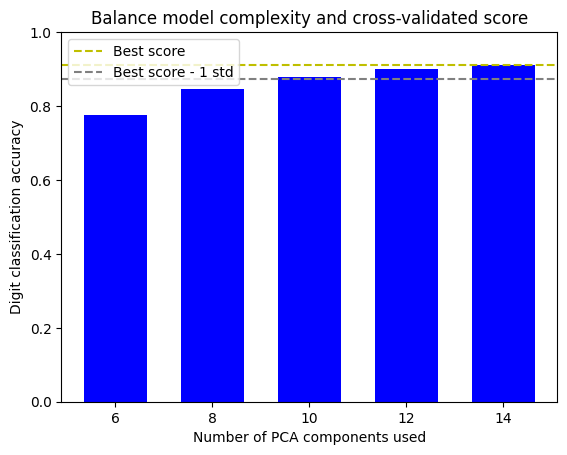

In [94]:
plt.figure()
plt.bar(n_components, test_scores, width=1.3, color="b")

lower = lower_bound(grid.cv_results_)
plt.axhline(np.max(test_scores), linestyle="--", color="y", label="Best score")
plt.axhline(lower, linestyle="--", color=".5", label="Best score - 1 std")

plt.title("Balance model complexity and cross-validated score")
plt.xlabel("Number of PCA components used")
plt.ylabel("Digit classification accuracy")
plt.xticks(n_components.tolist())
plt.ylim((0, 1.0))
plt.legend(loc="upper left")

best_index_ = grid.best_index_

print("The best_index_ is %d" % best_index_)
print("The n_components selected is %d" % n_components[best_index_])
print(
    "The corresponding accuracy score is %.2f"
    % grid.cv_results_["mean_test_score"][best_index_]
)
plt.show()

The figure shows the trade-off between cross-validated score and the number of PCA components. The balanced case is when n_components=10 and accuracy=0.88, which falls into the range within 1 standard deviation of the best accuracy score.